### This IPython book is implementaion of Kaggle Challenge https://www.kaggle.com/c/shelter-animal-outcomes

In [9]:
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

## Reading Data

In [8]:
train_df=pd.read_csv("train.csv")
test_df=pd.read_csv("test.csv") 

In [6]:
train_df.head()
test_df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White


## Analysis of Data 

['OutcomeType', 'OutcomeSubtype', 'AnimalType', 'SexuponOutcome']


Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64

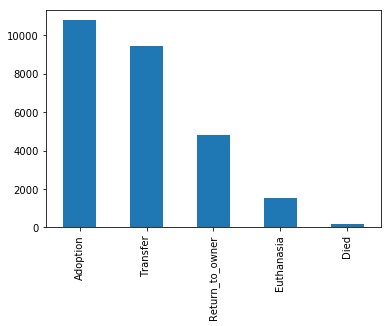

Partner                7816
Foster                 1800
SCRP                   1599
Suffering              1002
Aggressive              320
Offsite                 165
In Kennel               114
Behavior                 86
Rabies Risk              74
Medical                  66
In Foster                52
Enroute                   8
Court/Investigation       6
At Vet                    4
In Surgery                3
Barn                      2
Name: OutcomeSubtype, dtype: int64

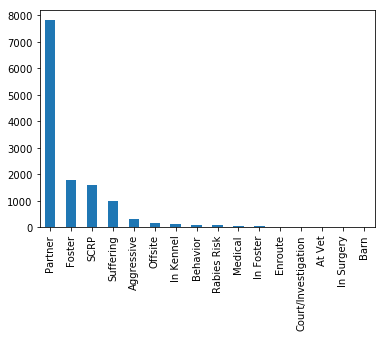

Dog    15595
Cat    11134
Name: AnimalType, dtype: int64

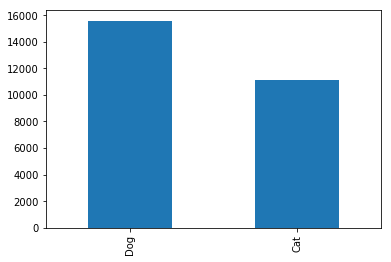

Neutered Male    9779
Spayed Female    8820
Intact Male      3525
Intact Female    3511
Unknown          1093
Name: SexuponOutcome, dtype: int64

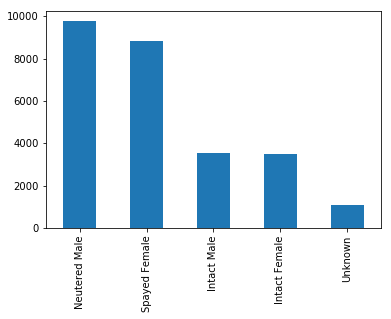

In [15]:
columns=["OutcomeType","OutcomeSubtype","AnimalType","SexuponOutcome"]
print(columns)
for column in columns:
    train_df[column].value_counts()
    train_df[column].value_counts().plot.bar()
    plt.show()
    
# test_df.SexuponOutcome.value_counts

In [16]:
def cleaning(data,is_train):
    data['HasName']=1
    data['HasName'][data["Name"].isnull()]=0
    data['AnimalType']=data["AnimalType"].map({'Cat':0,'Dog':1})
    data["SexuponOutcome"]=data["SexuponOutcome"].map({'Neutered Male':1, 'Spayed Female':2, 'Intact Male':3, 'Intact Female':4, 'Unknown':5, np.nan:0})
    if(is_train):
        data["OutcomeType"]=data['OutcomeType'].map({'Return_to_owner':4, 'Euthanasia':3, 'Adoption':0, 'Transfer':1, 'Died':2})
        data.drop(["AnimalID","OutcomeSubtype"],axis=1,inplace=True)
    else:
        data.drop(["ID"],axis=1,inplace=True)
        
    def ageToDays(x):
        try:
            y=x.split()
        except:
            return None
        
        if 'year' in y[1]:
            return float(y[0]) * 365
        elif 'month' in y[1]:
            return float(y[0]) * (365/12)
        elif 'week' in y[1]:
            return float(y[0]) * 7
        elif 'day' in y[1]:
            return float(y[0])
    data["AgeInDays"]=data["AgeuponOutcome"].map(ageToDays)
    data.loc[(data['AgeInDays'].isnull()),'AgeInDays'] = data['AgeInDays'].median()
    data['IsMix'] = data['Breed'].str.contains('mix',case=False).astype(int)
    return data.drop(["AgeuponOutcome","Name","Breed","Color","DateTime"],axis=1)


In [17]:
train_clean=cleaning(train_df.copy(),True)
test_clean=cleaning(test_df.copy(),False)
train_clean.head()
test_clean.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,OutcomeType,AnimalType,SexuponOutcome,HasName,AgeInDays,IsMix
0,4,1,1,1,365.0,1
1,3,0,2,1,365.0,1
2,0,1,1,1,730.0,1
3,1,0,3,0,21.0,1
4,1,1,1,0,730.0,0


,AnimalType,SexuponOutcome,HasName,AgeInDays,IsMix
0,1,4,1,304.166667,1
1,1,2,1,730.000000,0
2,0,1,1,365.000000,1
3,1,3,1,121.666667,1
4,1,1,1,730.000000,1


## Splitting Data

In [19]:
train, test = np.split(train_clean.sample(frac=1).values, [int(.8*len(train_clean))])

## Using Random Forest

In [22]:
forest=RandomForestClassifier(n_estimators=4000,max_features='auto')
forest=forest.fit(train[0::,1::],train[0::,0])

In [24]:
prediction=forest.predict(test[:,1:])
random_forest_accuracy=metrics.accuracy_score(prediction,test[:,0])
print("Random Forest accuracy=",random_forest_accuracy)

Random Forest accuracy= 0.642723531612


In [ ]:
# output = pd.DataFrame(prediction,columns=['Adoption','Died','Euthanasia','Return_to_owner','Transfer'])
# output["actual"]=test[:,0]

## Using Naive_bayes

In [25]:
naive_bayes=GaussianNB()
naive_bayes=naive_bayes.fit(train[0::,1::],train[0::,0])

In [26]:
n_prediction=naive_bayes.predict(test[:,1:])

In [28]:
naive_bayes_accuracy=metrics.accuracy_score(n_prediction,test[:,0])
print("Naive Bayes accuracy=",naive_bayes_accuracy)

Naive Bayes accuracy= 0.572951739618


## Using Neural Network

In [29]:
from keras.models import Sequential
from keras.layers import Dense 
from keras.utils import np_utils

Using TensorFlow backend.


In [31]:
def create_model():
    model=Sequential()
    model.add(Dense(32,input_dim=5,activation='relu'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(5,activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    return model
    

In [32]:
model=create_model()
train_y=np_utils.to_categorical(train[0::,0])  
model.fit(train[0::,1::],train_y,epochs=500)

Epoch 1/500
21383/21383 [==============================] - 0s - loss: 2.7548 - acc: 0.4481     
Epoch 2/500
21383/21383 [==============================] - 0s - loss: 1.2352 - acc: 0.4932     
Epoch 3/500
21383/21383 [==============================] - 0s - loss: 1.1958 - acc: 0.4959     
Epoch 4/500
21383/21383 [==============================] - 0s - loss: 1.1660 - acc: 0.5000     
Epoch 5/500
21383/21383 [==============================] - 0s - loss: 1.1680 - acc: 0.4931     
Epoch 6/500
21383/21383 [==============================] - 0s - loss: 1.1616 - acc: 0.4997     
Epoch 7/500
21383/21383 [==============================] - 0s - loss: 1.1662 - acc: 0.4901     
Epoch 8/500
21383/21383 [==============================] - 0s - loss: 1.1498 - acc: 0.5012     
Epoch 9/500
21383/21383 [==============================] - 0s - loss: 1.1570 - acc: 0.4949     
Epoch 10/500
21383/21383 [==============================] - 0s - loss: 1.1514 - acc: 0.5006     
Epoch 11/500
21383/21383 [=============

21383/21383 [==============================] - 0s - loss: 0.8992 - acc: 0.6205     
Epoch 86/500
21383/21383 [==============================] - 0s - loss: 0.8972 - acc: 0.6233     
Epoch 87/500
21383/21383 [==============================] - 0s - loss: 0.9032 - acc: 0.6201     
Epoch 88/500
21383/21383 [==============================] - 0s - loss: 0.9011 - acc: 0.6215     
Epoch 89/500
21383/21383 [==============================] - 0s - loss: 0.8958 - acc: 0.6231     
Epoch 90/500
21383/21383 [==============================] - 0s - loss: 0.8938 - acc: 0.6251     
Epoch 91/500
21383/21383 [==============================] - 0s - loss: 0.8947 - acc: 0.6247     
Epoch 92/500
21383/21383 [==============================] - 0s - loss: 0.8921 - acc: 0.6241     
Epoch 93/500
21383/21383 [==============================] - 0s - loss: 0.8964 - acc: 0.6233     
Epoch 94/500
21383/21383 [==============================] - 0s - loss: 0.8937 - acc: 0.6248     
Epoch 95/500
21383/21383 [=================

21383/21383 [==============================] - 0s - loss: 0.8607 - acc: 0.6370     
Epoch 169/500
21383/21383 [==============================] - 0s - loss: 0.8612 - acc: 0.6370     
Epoch 170/500
21383/21383 [==============================] - 0s - loss: 0.8591 - acc: 0.6379     
Epoch 171/500
21383/21383 [==============================] - 0s - loss: 0.8589 - acc: 0.6379     
Epoch 172/500
21383/21383 [==============================] - 0s - loss: 0.8585 - acc: 0.6394     
Epoch 173/500
21383/21383 [==============================] - 0s - loss: 0.8596 - acc: 0.6397     
Epoch 174/500
21383/21383 [==============================] - 0s - loss: 0.8612 - acc: 0.6371     
Epoch 175/500
21383/21383 [==============================] - 0s - loss: 0.8606 - acc: 0.6366     
Epoch 176/500
21383/21383 [==============================] - 0s - loss: 0.8568 - acc: 0.6396     
Epoch 177/500
21383/21383 [==============================] - 0s - loss: 0.8582 - acc: 0.6388     
Epoch 178/500
21383/21383 [=======

21383/21383 [==============================] - 0s - loss: 0.8513 - acc: 0.6414     
Epoch 252/500
21383/21383 [==============================] - 0s - loss: 0.8529 - acc: 0.6419     
Epoch 253/500
21383/21383 [==============================] - 0s - loss: 0.8528 - acc: 0.6399     
Epoch 254/500
21383/21383 [==============================] - 0s - loss: 0.8504 - acc: 0.6437     
Epoch 255/500
21383/21383 [==============================] - 0s - loss: 0.8530 - acc: 0.6426     
Epoch 256/500
21383/21383 [==============================] - 0s - loss: 0.8509 - acc: 0.6424     
Epoch 257/500
21383/21383 [==============================] - 0s - loss: 0.8541 - acc: 0.6397     
Epoch 258/500
21383/21383 [==============================] - 0s - loss: 0.8519 - acc: 0.6437     
Epoch 259/500
21383/21383 [==============================] - 0s - loss: 0.8529 - acc: 0.6415     
Epoch 260/500
21383/21383 [==============================] - 0s - loss: 0.8552 - acc: 0.6394     
Epoch 261/500
21383/21383 [=======

21383/21383 [==============================] - 0s - loss: 0.8506 - acc: 0.6434     
Epoch 335/500
21383/21383 [==============================] - 0s - loss: 0.8495 - acc: 0.6436     
Epoch 336/500
21383/21383 [==============================] - 0s - loss: 0.8493 - acc: 0.6448     
Epoch 337/500
21383/21383 [==============================] - 0s - loss: 0.8500 - acc: 0.6434     
Epoch 338/500
21383/21383 [==============================] - 0s - loss: 0.8488 - acc: 0.6433     
Epoch 339/500
21383/21383 [==============================] - 0s - loss: 0.8543 - acc: 0.6410     
Epoch 340/500
21383/21383 [==============================] - 0s - loss: 0.8485 - acc: 0.6438     
Epoch 341/500
21383/21383 [==============================] - 0s - loss: 0.8498 - acc: 0.6445     
Epoch 342/500
21383/21383 [==============================] - 0s - loss: 0.8530 - acc: 0.6429     
Epoch 343/500
21383/21383 [==============================] - 0s - loss: 0.8485 - acc: 0.6445     
Epoch 344/500
21383/21383 [=======

21383/21383 [==============================] - 0s - loss: 0.8476 - acc: 0.6437     
Epoch 418/500
21383/21383 [==============================] - 0s - loss: 0.8499 - acc: 0.6427     
Epoch 419/500
21383/21383 [==============================] - 0s - loss: 0.8485 - acc: 0.6415     
Epoch 420/500
21383/21383 [==============================] - 0s - loss: 0.8455 - acc: 0.6455     
Epoch 421/500
21383/21383 [==============================] - 0s - loss: 0.8473 - acc: 0.6450     
Epoch 422/500
21383/21383 [==============================] - 0s - loss: 0.8465 - acc: 0.6454     
Epoch 423/500
21383/21383 [==============================] - 0s - loss: 0.8483 - acc: 0.6428     
Epoch 424/500
21383/21383 [==============================] - 0s - loss: 0.8468 - acc: 0.6441     
Epoch 425/500
21383/21383 [==============================] - 0s - loss: 0.8466 - acc: 0.6435     
Epoch 426/500
21383/21383 [==============================] - 0s - loss: 0.8472 - acc: 0.6439     
Epoch 427/500
21383/21383 [=======

21383/21383 [==============================] - 0s - loss: 0.8453 - acc: 0.6447     


In [33]:
keras_prediction=model.predict(test[0::,1::])

In [34]:
neural_net_accuracy=metrics.accuracy_score(np.argmax(keras_prediction,axis=1),test[:,0])
print("Neural Network accuracy=",neural_net_accuracy)

Neural Network accuracy= 0.634306023195


In [35]:
model.evaluate(test[0::,1::],np_utils.to_categorical(test[0::,0]))

2624/5346 [=============>................] - ETA: 0s

[0.87037942660822654, 0.63430602319491214]

## Accuracy Comparision

<Container object of 3 artists>

([<matplotlib.axis.XTick at 0x6a71a5c0>,
 <a list of 3 Text xticklabel objects>)

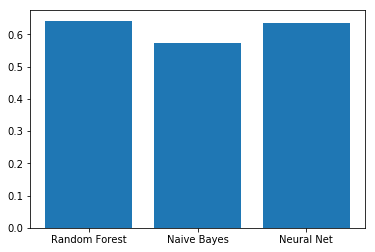

In [45]:
accuracy=[{"Random Forest",random_forest_accuracy},("Naive Bayes",naive_bayes_accuracy),("Neural Net",neural_net_accuracy)]
labels, ys = zip(*accuracy)
xs = np.arange(len(labels))
# print(xs)
plt.bar(xs,ys)
plt.xticks(xs,labels)